In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
    ExperienceReplayConfig,
    DataValuationConfig,
    RouterConfig,
    BoltzmanExplorationConfig,
)
from shell_data.utils.record import Record, snapshot_perf, snapshot_conf_mat
import numpy as np
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent
from shell_data.shell_agent.shell_agent_sender_first import ShellAgentSenderFirst
from itertools import combinations
import umap
from copy import deepcopy
from functools import partial


from shell_data.utils.utils import train
import matplotlib.pyplot as plt
# import mplcyberpunk
# plt.style.use("cyberpunk")
# plt.style.use('bmh')
import seaborn as sns
plt.style.use("fivethirtyeight")
# plt.style.use("xkcd")
sns.set_style("whitegrid")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import random
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)

SEED = 69
seed_everything(SEED)

2023-02-13 18:22:38.026395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 18:22:38.594056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-13 18:22:38.594110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-13 18:22:38.594113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

69

In [3]:
num_cls_per_task = 5
n_agents = 2
num_task_per_life = 2
buffer_integration_size = 50000  # sample all!
batch_size = 32
size = 64
routing_method = "random"

dataset_name = "mnist"

In [4]:
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
        dataset_name)

In [5]:
cfg = ShELLDataSharingConfig(
        n_agents=n_agents,
        dataset=DatasetConfig(
            name=dataset_name,
            train_size=size,
            test_size=1.0,
            val_size=size//2,
            num_task_per_life=num_task_per_life,
            num_cls_per_task=num_cls_per_task,
        ),
        task_model=TaskModelConfig(
            name=dataset_name,
        ),
        training=TrainingConfig(
            n_epochs=50,
            batch_size=batch_size,
            patience=1000,
            val_every_n_epoch=1,
        ),
        experience_replay=ExperienceReplayConfig(
            buffer_size=buffer_integration_size,
        ),
          router=RouterConfig(
            strategy=routing_method,  # control how the sender decides which data point to send
            num_batches=1,
            estimator_task_model=TaskModelConfig(
                name=dataset_name,
            ),
            n_heads=n_agents,
          ),
    )

In [6]:
receiver = ShellAgentSenderFirst(
        train_subsets, val_subsets, test_subsets, cfg)


sender_cfg = deepcopy(cfg)
# sender_cfg.dataset.train_size = 1.0 # all of the data for testing purposes...
sender = ShellAgentSenderFirst(
        train_subsets, val_subsets, test_subsets, sender_cfg)



receiver.ll_dataset.perm = torch.tensor([0, 1, 3, 4, 9,     2, 5, 6, 7, 8])
sender.ll_dataset.perm = torch.tensor([0, 4, 9, 2, 5,       1, 3, 6, 7, 8])


# intersection be 0, 4, 9 (and 2 out of distribution!)

receiver.init()
sender.init()

train_size: 64, num_cls_per_task: 5
train_size: 64, num_cls_per_task: 5


In [7]:
receiver_data = receiver.ll_dataset.get_train_dataset(0, kind="all")
sender_data = sender.ll_dataset.get_train_dataset(0, kind="all")


In [8]:
X_receiver = torch.stack([x for x, _ in receiver_data])
X_sender = torch.stack([x for x, _ in sender_data])

y_sender = torch.tensor([y for _, y in sender_data])
y_receiver = torch.tensor([y for _, y in receiver_data])

In [9]:
y_receiver_remap = torch.zeros_like(y_receiver)
for i, y in enumerate(torch.unique(y_receiver)):
    y_receiver_remap[y_receiver == y] = i

receiver_data_remapped = torch.utils.data.TensorDataset(X_receiver, y_receiver_remap)


receiver_dataloader =  torch.utils.data.DataLoader(
    receiver_data_remapped,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

## Unsupervised OOD Loss + Contrastive Loss (supervised)

In [10]:
from pytorch_ood.loss import CACLoss, IILoss, CenterLoss
import torch.nn as nn
from shell_data.shell_agent.contrastive import SupConLoss
import torchvision.transforms as transforms

In [14]:
class MNISTImageSimOpenSetRecognizer(nn.Module):
    def __init__(self, n_out=10) -> None:
        nn.Module.__init__(self)
        self.n_out = n_out
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
        )
        # output size: 8 * 2 * 2 = 32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid(),
        )

        # take in the encoded representation and output the class
        self.model = nn.Sequential(
            nn.Linear(8 * 2 * 2, 32),
            nn.ReLU(True),
            nn.Linear(32, n_out),
        )
        self.to("cpu")


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = x.view(-1, 8 * 2 * 2)
        x = self.model(x)
        return x

In [16]:
N_CLASSES = 5

scl = SupConLoss(device="cpu")
cac = CACLoss(n_classes=N_CLASSES)
mse = nn.MSELoss()
# cac = IILoss(n_classes=N_CLASSES, n_embedding=N_CLASSES)


n_epochs = 500


losses = []
cont_losses = []
rec_losses = []
cen_losses = []



model = MNISTImageSimOpenSetRecognizer(n_out=N_CLASSES) 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



for i in range(n_epochs):
    for batch in receiver_dataloader:
        x, y = batch


        ## CONTRASIVE LOSS
        train_transform = transforms.Compose([
                        # transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
                        transforms.RandomResizedCrop(size=28, scale=(0.2, 1.)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomApply([
                            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
                        ], p=0.8),
                        transforms.RandomGrayscale(p=0.2),
                    ])

        encoded_transformed_images = model.encoder(train_transform(x))
        encoded_images = model.encoder(x)

        encoded_transformed_images = encoded_transformed_images.view(
            encoded_transformed_images.shape[0], -1)
        encoded_images = encoded_images.view(
            encoded_images.shape[0], -1)

        features = torch.cat(
            [encoded_transformed_images.unsqueeze(1), 
                encoded_images.unsqueeze(1)], dim=1)

        cont_loss = scl(features, y)

        ## RECONSTRUCTION LOSS
        rec_loss = torch.tensor(0.0)
        # rec = model.decoder(model.encoder(x))
        # rec_loss = mse(rec, x)

        ## CAC LOSS
        z = model(x)
        distances = cac.calculate_distances(z)
        cac_loss = cac(distances, y)

        loss = cont_loss + cac_loss + rec_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        cont_losses.append(cont_loss.item())
        rec_losses.append(rec_loss.item())
        cen_losses.append(cac_loss.item())

/home/vlongle/miniconda3/envs/data-sharing/lib/python3.9/site-packages/pytorch_ood/loss/cac.py:80: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:631.)
  non_target[is_last_class, target_known[is_last_class]


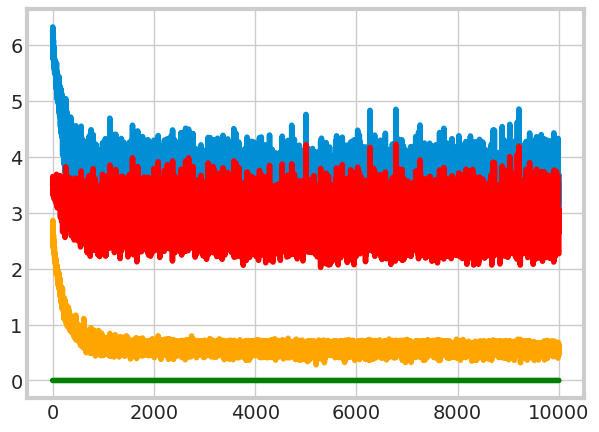

In [17]:
plt.plot(losses);
plt.plot(cont_losses, color='red');
plt.plot(rec_losses, color='green');
plt.plot(cen_losses, color='orange');

In [18]:
def contrastive_callable(network, X):
    """
    This function is called by the ContrastiveModel
    """
    encoded_images = network.encoder(X).view(X.shape[0], -1)
    return encoded_images

In [19]:
import torch.nn.functional as F
def image_search(queries, database, reducer_callable, n_neighbors=10, p=2, metric="distance"):
    query_embed = reducer_callable(X=queries)
    database_embed = reducer_callable(X=database)
    if metric == "distance":
        dist = torch.cdist(query_embed, database_embed, p=p)
    elif metric == "cosine":
        dist = 1 - torch.stack([F.cosine_similarity(query_embed[i], database_embed) for i in range(len(query_embed))])
    else:
        raise ValueError(f"metric {metric} is not supported")
    closest_dist, closest_idx = torch.topk(dist, k=n_neighbors, dim=1, largest=False)
    return closest_dist, closest_idx

In [50]:
"""
Pick some random images from receiver and plot the neighbors from sender
returned above
"""

def viz_image_search(queries, database, closest_idx, closest_dist):
    num_images = min(10, len(queries))
    n_neighbors = 10
    x_idx = np.random.randint(0, len(queries), num_images)
    x = queries[x_idx]
    closest_idx = closest_idx[x_idx]

    fig, axes = plt.subplots(nrows=num_images, ncols=n_neighbors + 1, figsize=( 10, 12));
    for i, image in enumerate(x):
        axes[i, 0].imshow(image.cpu().squeeze(), cmap="gray");
        axes[i, 0].axis("off");
        for j in range(10):
            axes[i, j+1].imshow(database[closest_idx[i, j]].cpu().squeeze(), cmap="gray");
            axes[i, j+1].title.set_text(f"{closest_dist[i, j]:.2f}");
            axes[i, j+1].axis("off");
    
    plt.show();

In [51]:
def compute_img_search_quality(queries, database, query_y, database_y, closest_idx, n_neighbors=5):
    # for each query get the k nearest neighbors
    closest_idx = closest_idx.cpu()
    neighbor_idx = closest_idx[:, :n_neighbors]
    # compute the accuracy which is defined the fraction of database_y of neighbor_idx match with query_y
    neighbor_y = database_y[neighbor_idx]
    accuracy = (neighbor_y == query_y.unsqueeze(1)).sum(dim=1) / n_neighbors
    # accuracy per sample
    return accuracy

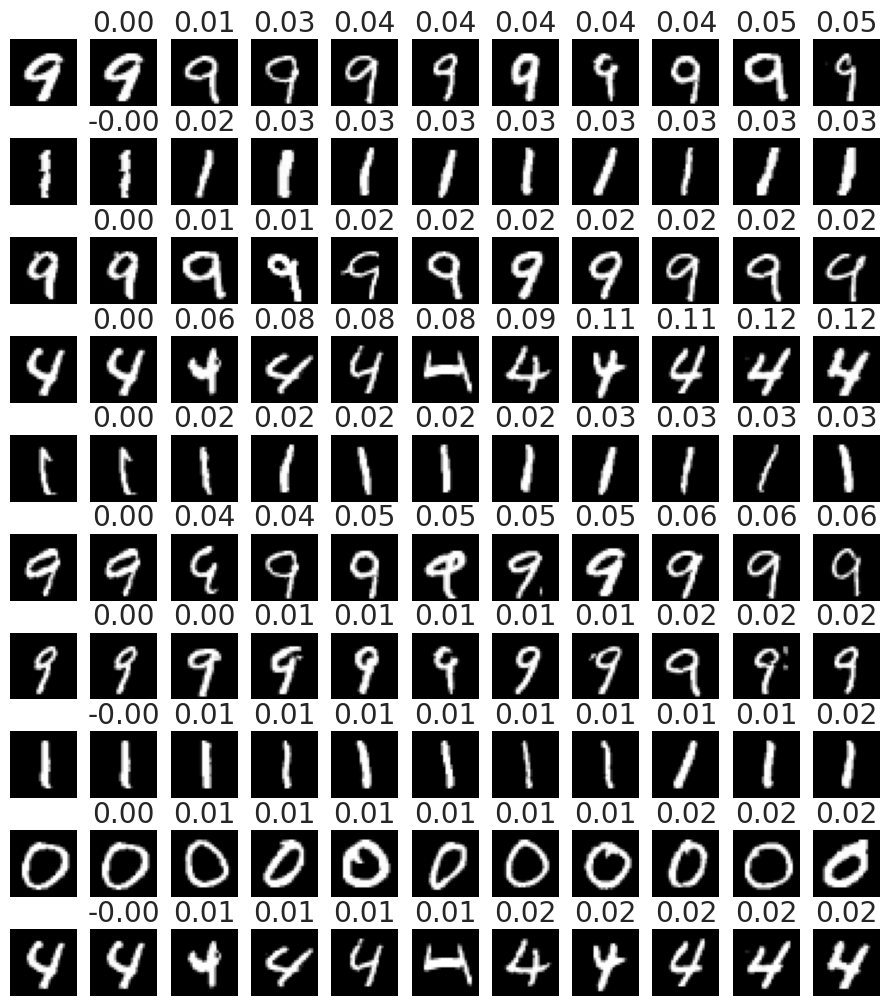

In [52]:
# training
closest_dist, closest_idx = image_search(X_receiver, X_receiver, reducer_callable=partial(contrastive_callable, network=model),
metric="cosine")

viz_image_search(X_receiver, X_receiver, closest_idx, closest_dist)

In [54]:
ae_training_retrieval_acc = compute_img_search_quality(X_receiver, X_receiver, y_receiver, y_receiver, closest_idx)
print(ae_training_retrieval_acc.mean())

tensor(0.9931)


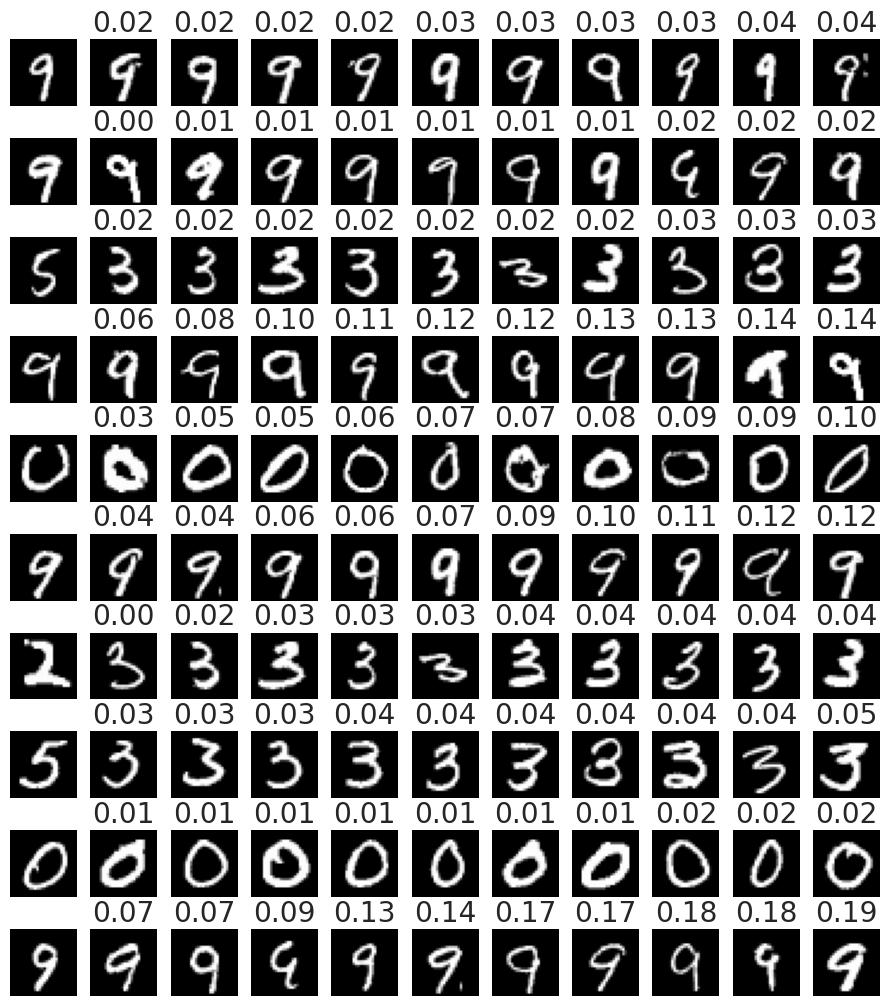

In [55]:
# testing
closest_dist, closest_idx = image_search(X_sender, X_receiver, reducer_callable=partial(contrastive_callable, network=model),
metric="cosine")
viz_image_search(X_sender, X_receiver, closest_idx, closest_dist)

In [56]:

ae_testing_retrieval_acc = compute_img_search_quality(X_sender, X_receiver, y_sender, y_receiver, closest_idx)
print(ae_testing_retrieval_acc.mean())
# filter out all rows that have 2 and 5 labels (OOD)
in_dist_testing_acc = ae_testing_retrieval_acc[(y_sender != 2) & (y_sender != 5)]
print(in_dist_testing_acc.mean())

tensor(0.5331)
tensor(0.8885)


In [26]:
torch.unique(in_dist_testing_acc, return_counts=True)

(tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000]),
 tensor([ 15,   2,   4,   3,   6, 162]))

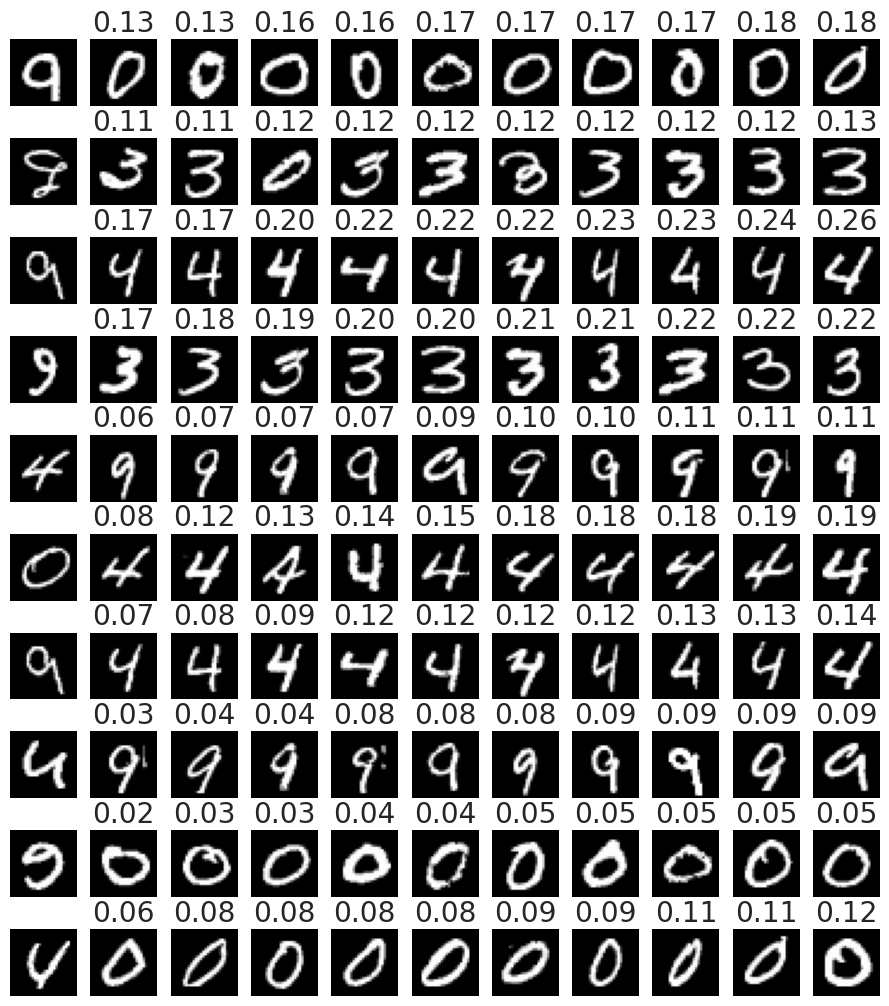

In [27]:
# viz the one that has 0.0 accuracy
in_dist = X_sender[(y_sender != 2) & (y_sender != 5)] 
outlier = in_dist[(in_dist_testing_acc == 0.0)]


# plot the outlier
closest_dist, closest_idx = image_search(outlier, X_receiver, reducer_callable=partial(contrastive_callable, network=model),
metric="cosine")

viz_image_search(outlier, X_receiver, closest_idx, closest_dist)

## Outlier detection

In [28]:
def outlier_score_cac(x, cac):
    with torch.no_grad():
        dist = cac.calculate_distances(model(x))
        outlier_score = cac.score(dist)
    return outlier_score

In [29]:
from pytorch_ood.detector import (
     ODIN,
     EnergyBased,
     KLMatching,
     Mahalanobis,
     MaxLogit,
     MaxSoftmax,
     ViM,
     MCD,
 )

receiver.load_model("./results/ood.pt")

receiver.model.net.to("cpu")

detector = Mahalanobis(receiver.model.net.features)
receiver_dataloader = torch.utils.data.DataLoader(
    receiver_data_remapped,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
detector.fit(receiver_dataloader, device="cpu")


def outlier_score_detector(x, detector):
    with torch.no_grad():
        outlier_score = detector(x)
    return outlier_score

In [30]:
def compute_img_search_quality(queries, database, query_y, database_y, closest_idx, n_neighbors=5):
    # for each query get the k nearest neighbors
    closest_idx = closest_idx.cpu()
    neighbor_idx = closest_idx[:, :n_neighbors]
    # compute the accuracy which is defined the fraction of database_y of neighbor_idx match with query_y
    neighbor_y = database_y[neighbor_idx]
    accuracy = (neighbor_y == query_y.unsqueeze(1)).sum(dim=1) / n_neighbors
    # accuracy per sample
    return accuracy

In [31]:
MCD_detector = KLMatching(receiver.model.net)
MCD_detector.fit(receiver_dataloader, device="cpu")

In [32]:
# train
train_cac_scores = outlier_score_cac(X_receiver, cac)
train_detector_scores = outlier_score_detector(X_receiver, detector)
train_MCD_detector_scores = outlier_score_detector(X_receiver, MCD_detector)

cac_upper_bound = train_cac_scores.mean() + 0.5 * train_cac_scores.std()
detector_upper_bound = train_detector_scores.mean() + 0.5 * train_detector_scores.std()
MCD_detector_upper_bound = train_MCD_detector_scores.mean() + 0.1 * train_MCD_detector_scores.std()

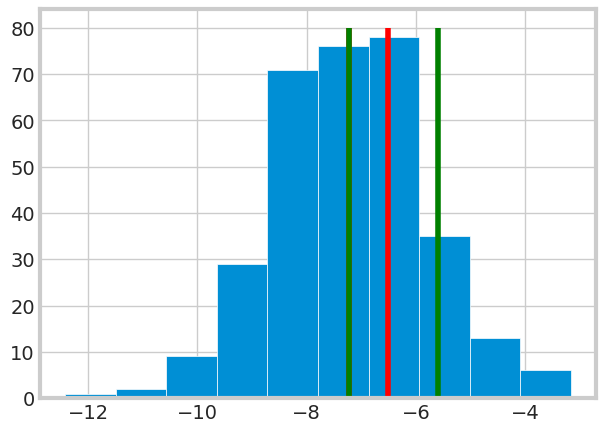

In [45]:
plt.hist(train_cac_scores);
# draw lines at mean and upper_bound
plt.vlines(train_cac_scores.mean(), 0, 80, color="red")
plt.vlines(cac_upper_bound, 0, 80, color="red")
plt.vlines(train_cac_scores.median(), 0, 80, color="green")
# 75th percentile
upper_percentile = np.quantile(train_cac_scores, 0.9)
plt.vlines(upper_percentile, 0, 80, color="green");

In [46]:
# testing
test_cac_scores = outlier_score_cac(X_sender, cac)
test_detector_scores = outlier_score_detector(X_sender, detector)
test_MCD_detector_scores = outlier_score_detector(X_sender, MCD_detector)

cac_outlier = test_cac_scores > cac_upper_bound
detector_outlier = test_detector_scores > detector_upper_bound
MCD_detector_outlier = test_MCD_detector_scores > MCD_detector_upper_bound

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


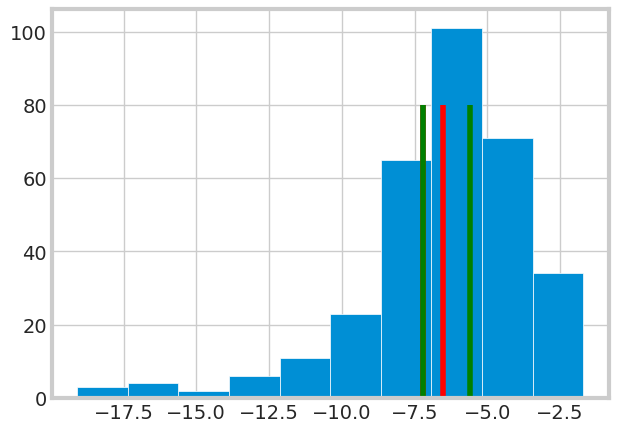

In [58]:
plt.hist(test_cac_scores);
# draw lines at mean and upper_bound
plt.vlines(train_cac_scores.mean(), 0, 80, color="red")
plt.vlines(cac_upper_bound, 0, 80, color="red")
plt.vlines(train_cac_scores.median(), 0, 80, color="green")
# 75th percentile
upper_percentile = np.quantile(train_cac_scores, 0.9)
plt.vlines(upper_percentile, 0, 80, color="green");

In [ ]:
def quality_outlier(y_outlier):
    outlier_classes = [2, 5]
    num_total_outliers = len(outlier_classes) * 64
    num_outliers_caught = 0
    for clz in outlier_classes:
        num_outliers_caught += (y_outlier == clz).sum().item() 

    acc = num_outliers_caught / len(y_outlier)
    false_positive_rate = 1 - acc
    detection_rate = num_outliers_caught / num_total_outliers
    print("acc:", acc)
    print("detecion rate:", detection_rate)
    print(torch.unique(y_outlier, return_counts=True))

In [ ]:
quality_outlier(y_sender[cac_outlier])

In [ ]:
quality_outlier(y_sender[detector_outlier])

In [ ]:
quality_outlier(y_sender[MCD_detector_outlier])

In [ ]:
ensemble_outlier = (cac_outlier & detector_outlier)
quality_outlier(y_sender[ensemble_outlier])

In [ ]:
# compute the image search quality again, but this time only on the in-distribution samples
# testing
closest_dist, closest_idx = image_search(X_sender, X_receiver, reducer_callable=partial(contrastive_callable, network=model),
metric="cosine")
viz_image_search(X_sender, X_receiver, closest_idx, closest_dist)

In [ ]:
torch.unique(y_sender[~cac_outlier], return_counts=True)

In [ ]:
torch.unique(y_sender[cac_outlier], return_counts=True)

In [ ]:

ae_testing_retrieval_acc = compute_img_search_quality(X_sender, X_receiver, y_sender, y_receiver, closest_idx)
print(ae_testing_retrieval_acc.mean())
# filter out all rows that have 2 and 5 labels (OOD)

in_dist_testing_acc = ae_testing_retrieval_acc[y_sender[~cac_outlier]]
print(in_dist_testing_acc.mean())

in_dist_testing_acc = ae_testing_retrieval_acc[y_sender[~detector_outlier]]
print(in_dist_testing_acc.mean())

in_dist_testing_acc = ae_testing_retrieval_acc[y_sender[~ensemble_outlier]]
print(in_dist_testing_acc.mean())
